In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [ ]:
df = pd.read_csv('30m.csv')
df = df[::-1]
df.index = df.index[::-1]

dfvol = pd.read_csv('vol.csv')
dfvol = dfvol[::-1]
dfvol.index = dfvol.index[::-1]
dfvol['Date'] = pd.to_datetime(dfvol['Date'], dayfirst = 1)

df.rename(columns = {'Date':'Datetime'}, inplace = True)
df['Date'] = pd.to_datetime(df['Datetime'], dayfirst = True).dt.date
df

,Datetime,Close,Date
0,26-08-2022 09:16,17632.0000,2022-08-26
1,26-08-2022 09:46,17625.0508,2022-08-26
2,26-08-2022 10:16,17600.5000,2022-08-26
3,26-08-2022 10:46,17588.5508,2022-08-26
4,26-08-2022 11:16,17615.9492,2022-08-26
...,...,...,...
1958,06-04-2023 13:16,17569.6504,2023-04-06
1959,06-04-2023 13:46,17579.4492,2023-04-06
1960,06-04-2023 14:16,17594.5000,2023-04-06
1961,06-04-2023 14:46,17594.8496,2023-04-06


In [ ]:
dfvol

,Date,Volatility,Volume
0,2022-08-26,12.70,266636240
1,2022-08-29,13.45,244854640
2,2022-08-30,20.10,324687488
3,2022-09-01,20.90,308526592
4,2022-09-02,20.27,256268608
...,...,...,...
147,2023-03-29,9.65,345911072
148,2023-03-31,12.52,263889040
149,2023-04-03,11.49,230170688
150,2023-04-05,11.80,248345200


In [ ]:
df['Volatility'] = [0]*len(df)
df['Volume'] = [0]*len(df)

dfvol.index = dfvol['Date']
for i in range(len(df)):
  df['Volatility'][i]=dfvol.loc[str(df['Date'][i])]['Volatility']
  df['Volume'][i]=dfvol.loc[str(df['Date'][i])]['Volume']

In [ ]:
df

,Datetime,Close,Date,Volatility,Volume
0,26-08-2022 09:16,17632.0000,2022-08-26,12.70,266636240
1,26-08-2022 09:46,17625.0508,2022-08-26,12.70,266636240
2,26-08-2022 10:16,17600.5000,2022-08-26,12.70,266636240
3,26-08-2022 10:46,17588.5508,2022-08-26,12.70,266636240
4,26-08-2022 11:16,17615.9492,2022-08-26,12.70,266636240
...,...,...,...,...,...
1958,06-04-2023 13:16,17569.6504,2023-04-06,11.81,242708336
1959,06-04-2023 13:46,17579.4492,2023-04-06,11.81,242708336
1960,06-04-2023 14:16,17594.5000,2023-04-06,11.81,242708336
1961,06-04-2023 14:46,17594.8496,2023-04-06,11.81,242708336


In [ ]:
a = np.array(dfvol['Volume'])
b = np.array(dfvol['Volatility'])
a.sort()
b.sort()
mid_low_volume = a[50]
mid_high_volume = a[100]
mid_low_volatility = b[50]
mid_high_volatility = b[100]

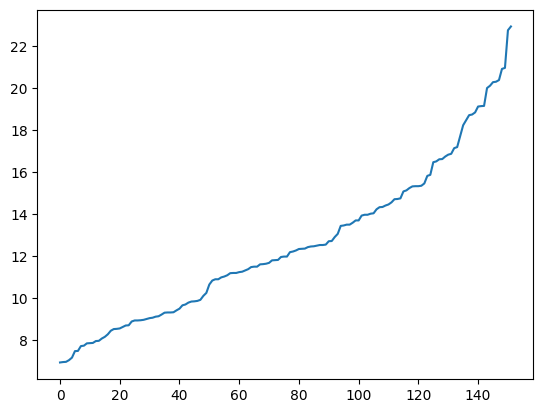

In [ ]:
plt.plot(b)

In [ ]:
df['tag_vt'] = [0]*len(df)
for i in range(len(df)):
  if df['Volatility'][i] >= mid_high_volatility:
    df['tag_vt'][i] = 'h'
  elif df['Volatility'][i] <= mid_low_volatility:
    df['tag_vt'][i] = 'l'
  else:
    df['tag_vt'][i] = 'm'

df['tag_vm'] = [0]*len(df)
for i in range(len(df)):
  if df['Volume'][i] >= mid_high_volume:
    df['tag_vm'][i] = 'h'
  elif df['Volume'][i] <= mid_low_volume:
    df['tag_vm'][i] = 'l'
  else:
    df['tag_vm'][i] = 'm'


In [ ]:
rets = df['Close'].pct_change()
df['Returns'] = rets

In [ ]:
# Making new dataframes with assigned tags based on volatility
df_vtl = df[df['tag_vt'] == 'l']
df_vtm = df[df['tag_vt'] == 'm']
df_vth = df[df['tag_vt'] == 'h']

# Making new dataframes with assigned tags based on volume
df_vml = df[df['tag_vm'] == 'l']
df_vmm = df[df['tag_vm'] == 'm']
df_vmh = df[df['tag_vm'] == 'h']

In [ ]:
def fl_strat_ret(df):
  df.index = range(len(df))
  df['fl signal'] = [0]*len(df)
  for i in range(df.shape[0]//13):
    if df.iloc[i*13+1]['Returns']>0:
      df['fl signal'][i*13+12] = 1
    elif df.iloc[i*13+1]['Returns']<0:
      df['fl signal'][i*13+12] = -1

  df1 = df[12::13]
  df1['fl strategy'] = [0]*len(df1)

  df1['fl strategy'] = df1['Returns']*df1['fl signal']
  df1['fl returns'] = df1['fl strategy'].cumsum()

  return df1

def fl_strat_ret_cont(df):
  df.index = range(len(df))
  df['fl signal'] = [0]*len(df)
  for i in range(df.shape[0]//13):
    if df.iloc[i*13+1]['Returns']>0:
      df['fl signal'][i*13+12] = -1
    elif df.iloc[i*13+1]['Returns']<0:
      df['fl signal'][i*13+12] = 1

  df1 = df[12::13]
  df1['fl strategy'] = [0]*len(df1)

  df1['fl strategy'] = df1['Returns']*df1['fl signal']
  df1['fl returns'] = df1['fl strategy'].cumsum()

  return df1

def stats(data):
  # calculate the Sharpe Ratio, Skewness, and Kurtosis of the returns
  sharpe_ratio = np.sqrt(252) * data['fl strategy'].mean() / data['fl strategy'].std()
  skewness = skew(data['fl strategy'])
  krt = kurtosis(data['fl strategy'])

  return [sharpe_ratio, skewness, krt]

def percent_profitability(df, scenario):
  total_trades = len(df[df['fl strategy']!=0])
  profitable_trades = len(df[df['fl strategy']>0])
  percent = round(100*profitable_trades/total_trades,2)

  print("Profitable trades on", scenario, "days: ", profitable_trades, "/", total_trades, "=", percent, "%")
  return percent

In [ ]:
vt_h = fl_strat_ret(df_vth)
vt_m = fl_strat_ret(df_vtm)
vt_l = fl_strat_ret(df_vtl)

vm_h = fl_strat_ret(df_vmh)
vm_m = fl_strat_ret(df_vmm)
vm_l = fl_strat_ret(df_vml)

v_all = fl_strat_ret(df)

In [ ]:
vt_h_cont = fl_strat_ret_cont(df_vth)
vt_m_cont = fl_strat_ret_cont(df_vtm)
vt_l_cont = fl_strat_ret_cont(df_vtl)
vm_h_cont = fl_strat_ret_cont(df_vmh)
vm_m_cont = fl_strat_ret_cont(df_vmm)
vm_l_cont = fl_strat_ret_cont(df_vml)

v_all_cont = fl_strat_ret_cont(df)

In [ ]:
v_all

,Datetime,Close,Date,Volatility,Volume,tag_vt,tag_vm,Returns,fl signal,fl strategy,fl returns
12,26-08-2022 15:16,17574.1992,2022-08-26,12.70,266636240,m,m,-0.000464,-1,0.000464,0.000464
25,29-08-2022 15:16,17310.8496,2022-08-29,13.45,244854640,m,m,0.000442,1,0.000442,0.000906
38,30-08-2022 15:16,17768.6504,2022-08-30,20.10,324687488,h,h,0.000797,1,0.000797,0.001703
51,01-09-2022 15:16,17545.1504,2022-09-01,20.90,308526592,h,h,-0.000159,1,-0.000159,0.001543
64,02-09-2022 15:16,17537.6992,2022-09-02,20.27,256268608,h,m,-0.000880,-1,0.000880,0.002423
...,...,...,...,...,...,...,...,...,...,...,...
1910,29-03-2023 15:16,17100.1992,2023-03-29,9.65,345911072,l,h,0.000521,1,0.000521,0.014728
1923,31-03-2023 15:16,17341.5000,2023-03-31,12.52,263889040,m,m,-0.001186,-1,0.001186,0.015915
1936,03-04-2023 15:16,17401.0996,2023-04-03,11.49,230170688,m,m,-0.000282,-1,0.000282,0.016196
1949,05-04-2023 15:16,17562.4492,2023-04-05,11.80,248345200,m,m,0.000630,1,0.000630,0.016826


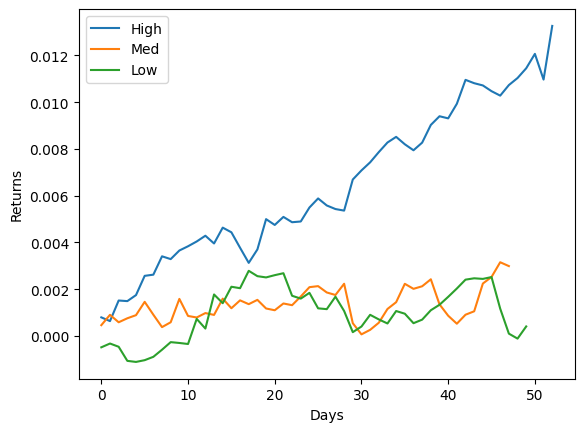

In [ ]:
plt.plot(vt_h['fl returns'].values, label = 'High')
plt.plot(vt_m['fl returns'].values, label = 'Med')
plt.plot(vt_l['fl returns'].values, label = 'Low')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()

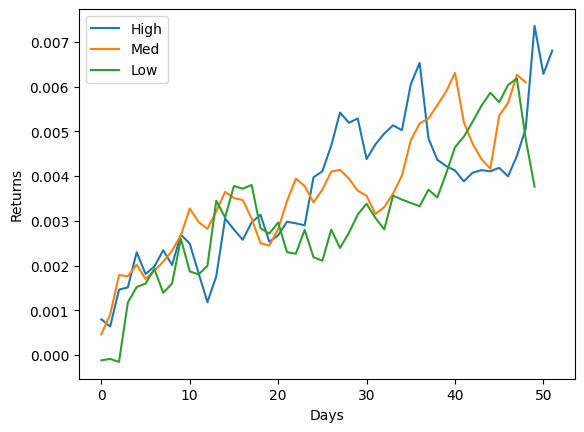

In [ ]:
plt.plot(vm_h['fl returns'].values, label = 'High')
plt.plot(vm_m['fl returns'].values, label = 'Med')
plt.plot(vm_l['fl returns'].values, label = 'Low')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()

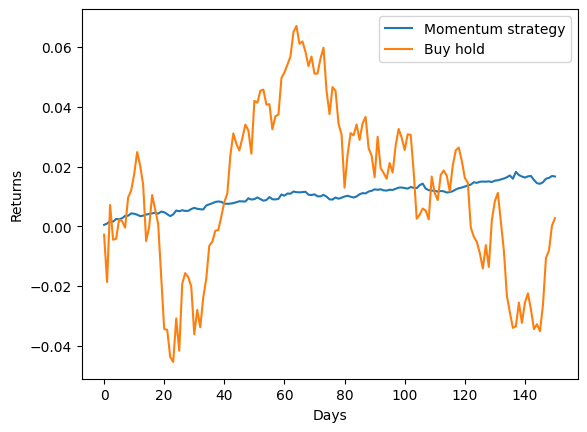

In [ ]:
plt.plot(v_all['fl returns'].values, label = 'Momentum strategy')
plt.plot([np.sum(df['Returns'][:i*13+12]) for i in range(len(v_all))], label = 'Buy hold')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
stats(v_all)

[3.237293859295557, 0.11143703922317488, 1.9574352360974778]

In [ ]:
  percent_profitability(vt_h, "High volatility")
percent_profitability(vt_m, "Medium volatility")
percent_profitability(vt_l, "Low volatility")
print("----------------------------------------------------")
percent_profitability(vm_h, "High volume")
percent_profitability(vm_m, "Medium volume")
percent_profitability(vm_l, "Low volume")
print("----------------------------------------------------")
percent_profitability(v_all, "ALL")

Profitable trades on High volatility days:  33 / 53 = 62.26 %
Profitable trades on Medium volatility days:  28 / 48 = 58.33 %
Profitable trades on Low volatility days:  25 / 50 = 50.0 %
----------------------------------------------------
Profitable trades on High volume days:  30 / 52 = 57.69 %
Profitable trades on Medium volume days:  29 / 49 = 59.18 %
Profitable trades on Low volume days:  27 / 50 = 54.0 %
----------------------------------------------------
Profitable trades on ALL days:  86 / 151 = 56.95 %


56.95

In [ ]:
summary = pd.DataFrame(columns = ['Sharpe ratio', 'Skewness', 'Kurtosis'], index = ['High vt', 'Med vt', 'Low vt', 'High vm', 'Med vm', 'Low vm' ])
all_dfs = [vt_h, vt_m, vt_l, vm_h, vm_m, vm_l]


for i in range(len(summary)):
  summary.iloc[i]  = stats(all_dfs[i])

summary['Profitable trades (in %)'] = [percent_profitability(all_dfs[i], summary.index[i]) for i in range(len(summary))]
summary['fl strat returns (in %)'] = [round(all_dfs[i]['fl returns'].iloc[-1]*100,2) for i in range(len(summary))]


Profitable trades on High vt days:  33 / 53 = 62.26 %
Profitable trades on Med vt days:  28 / 48 = 58.33 %
Profitable trades on Low vt days:  25 / 50 = 50.0 %
Profitable trades on High vm days:  30 / 52 = 57.69 %
Profitable trades on Med vm days:  29 / 49 = 59.18 %
Profitable trades on Low vm days:  27 / 50 = 54.0 %


In [ ]:
summary.sort_values(by = 'fl strat returns (in %)', ascending = 0)

,Sharpe ratio,Skewness,Kurtosis,Profitable trades (in %),fl strat returns (in %)
High vt,7.06689,0.768971,2.183743,62.26,1.33
High vm,3.26446,0.298035,2.10912,57.69,0.68
Med vm,4.678135,-0.199973,0.389751,59.18,0.61
Low vm,2.18609,-0.0775,0.704623,54.00,0.38
Med vt,1.913224,-0.740615,1.628951,58.33,0.30
Low vt,0.249853,-0.109508,0.86625,50.00,0.04


In [ ]:
statsvt_h

NameError: ignored

MPC Policy rate HIKE on 6-8 Feb meetings

In [ ]:
# Choose a 3 week period around these dates to analyse intraday momentum effect of this news event


df_mpc = df.iloc[1404:1664]
df_mpc_ret = round(fl_strat_ret(df_mpc)['fl returns'][len(df_mpc)-1]*100,2)
print('Return due to MPC news event (in', len(df_mpc)//13, 'days): ', df_mpc_ret, '%')
print('Annualized return: ', df_mpc_ret*(252//(len(df_mpc)//13)), '%')

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import linregress

In [ ]:
def LR(X, Y):
  # Reshape x and y to be 2D arrays
  x = np.array(X).reshape(-1, 1)
  y = np.array(Y).reshape(-1, 1)
  model = LinearRegression().fit(x,y)

  return model.score(x,y),


In [ ]:
# First half hour and last half hour
X = df['Returns'][1::13]
Y = df['Returns'][12::13]
linregress(X,Y)
#print('R2 Score:', round(LR(X,Y)*100,3), '%')

LinregressResult(slope=0.047092850333104334, intercept=-2.791861113098319e-05, rvalue=0.17652064816744725, pvalue=0.030147107950704397, stderr=0.021512578265857847, intercept_stderr=4.438104637279807e-05)

In [ ]:
# Full day return and last half hour
X = [np.sum(df['Returns'][i+1:i+12]) for i in range(151)]
Y = df['Returns'][12::13]
linregress(X,Y)
#print('R2 Score:', round(LR(X,Y)*100,4), '%')

LinregressResult(slope=0.000476003341295448, intercept=-2.471745269576402e-05, rvalue=0.006793079418331282, pvalue=0.9340248443100352, stderr=0.0057403735460535305, intercept_stderr=4.605881309079276e-05)

In [ ]:
# Previous day last half hour and today's first half hour
X = df['Returns'][12::13][:-1]
Y = df['Returns'][14::13]
linregress(X,Y)
#print('R2 Score:', round(LR(X,Y)*100,2), '%')

LinregressResult(slope=0.2448884720448312, intercept=9.367897967062408e-05, rvalue=0.06532973562287593, pvalue=0.42703349920929046, stderr=0.30746651184013396, intercept_stderr=0.00016975361628648902)

In [ ]:
# First half hour (including overnight return) and last half hour
X = [np.sum(df['Returns'][i*13+13:i*13+14]) for i in range(150)]
Y = df['Returns'][12::13][1:]
linregress(X,Y)
#print('R2 Score:', round(LR(X,Y)*100,2), '%')

LinregressResult(slope=-0.00866690142461526, intercept=-1.8196935108995567e-05, rvalue=-0.08913059446933021, pvalue=0.27807632941075705, stderr=0.007961121145849967, intercept_stderr=4.514947939687905e-05)

In [ ]:
# First half hour, Previous last hour and last half hour
dfp = pd.DataFrame()
dfp['f'] = df['Returns'][1::13][1:].values
dfp['pl'] = df['Returns'][12::13][:-1].values
# dfp['fpl'] = dfp['f'] * dfp['pl']
dfp['l'] = df['Returns'][12::13][1:].values
X = dfp[['f','pl']]
Y = dfp['l']
ml = LinearRegression().fit(X,Y)
print('R2 Score:', round(ml.score(X,Y)*100,3), '%')

R2 Score: 6.277 %


In [ ]:
import statsmodels.api as sm
import numpy as np

# Assuming x1 and x2 are the independent variables and y is the dependent variable
x1 = dfp['f']
x2 = dfp['pl']
y = dfp['l']

# Adding a constant term to the independent variables
X = sm.add_constant(np.column_stack((x1, x2)))

# Fitting a multiple linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Printing the summary of the regression results, including the p-values
print(model.summary())
model.p_values()

                            OLS Regression Results                            
Dep. Variable:                      l   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     4.923
Date:                Fri, 14 Apr 2023   Prob (F-statistic):            0.00852
Time:                        08:40:49   Log-Likelihood:                 917.70
No. Observations:                 150   AIC:                            -1829.
Df Residuals:                     147   BIC:                            -1820.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.949e-05    4.4e-05     -0.670      0.5

AttributeError: ignored

In [ ]:
ml.coef_

array([ 0.04989312, -0.1786657 ])

Implement Trading strategy using prev day last half hour and today first half hour

In [ ]:
def pfl_strat_ret(df):
  df.index = range(len(df))
  df['pfl signal'] = [0]*len(df)
  for i in range(150):
    if df.iloc[i*13+12]['Returns']<0 and df.iloc[i*13+14]['Returns']>0:
      df['pfl signal'][i*13+25] = 1
    elif df.iloc[i*13+12]['Returns']>0 and df.iloc[i*13+14]['Returns']<0:
      df['pfl signal'][i*13+25] = -1

  df1 = df[12::13]
  df1['pfl strategy'] = [0]*len(df1)

  df1['pfl strategy'] = df1['Returns']*df1['pfl signal']
  df1['pfl returns'] = df1['pfl strategy'].cumsum()

  return df1

def stats(data):
  # calculate the Sharpe Ratio, Skewness, and Kurtosis of the returns
  sharpe_ratio = np.sqrt(252) * data['pfl returns'].mean() / data['pfl returns'].std()
  skewness = skew(data['pfl returns'])
  krt = kurtosis(data['pfl returns'])

  return [sharpe_ratio, skewness, krt]

def percent_profitability(df, scenario):
  total_trades = len(df[df['pfl strategy']!=0])
  profitable_trades = len(df[df['pfl strategy']>0])
  percent = round(100*profitable_trades/total_trades,2)

  print("Profitable trades on", scenario, "days: ", profitable_trades, "/", total_trades, "=", percent, "%")
  return percent

In [ ]:
pfl = pfl_strat_ret(df)
len(pfl[pfl['pfl strategy']!=0])

71

In [ ]:
44/71

0.6197183098591549

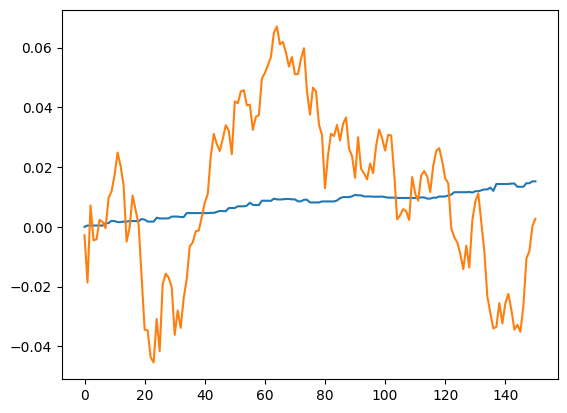

In [ ]:
plt.plot(pfl['pfl returns'].values)
plt.plot([np.sum(df['Returns'][:i*13+12]) for i in range(len(pfl))])

Text(0, 0.5, 'Returns (in %)')

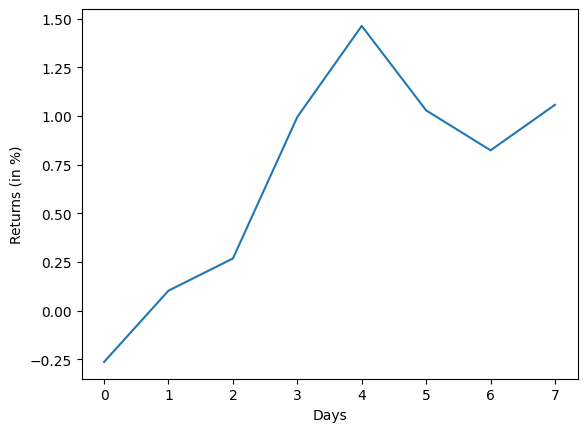

In [ ]:
# Choose a 3 week period around these dates to analyse intraday momentum effect of this news event

df_mpc = df.iloc[1405:1521]
a = fl_strat_ret(df_mpc)
plt.plot(range(len(a)), a['fl returns']*100)
plt.xlabel('Days')
plt.ylabel('Returns (in %)')

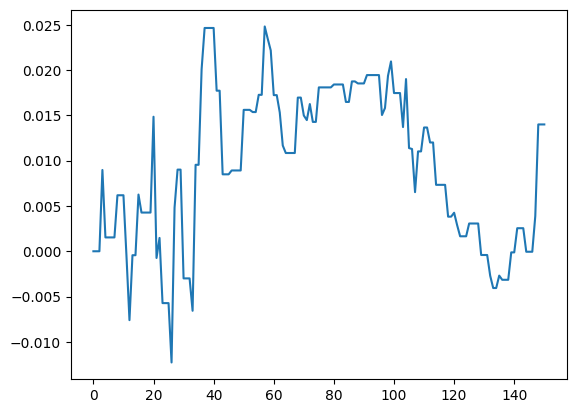

In [ ]:
on_ret = [np.sum(df['Returns'][::13].values[2:i]) for i in range(151)]
plt.plot(on_ret)
plt.plot()

In [ ]:
max_drawdown = round(min(on_ret)*100,2)
max_drawdown, '%'

(-1.23, '%')

Day-wise return plotting

In [ ]:
df[:15]


,Datetime,Close,Date,Volatility,Volume,tag_vt,tag_vm,Returns,fl signal
0,26-08-2022 09:16,17632.0000,2022-08-26,12.70,266636240,m,m,NaN,0
1,26-08-2022 09:46,17625.0508,2022-08-26,12.70,266636240,m,m,-0.000394,0
2,26-08-2022 10:16,17600.5000,2022-08-26,12.70,266636240,m,m,-0.001393,0
3,26-08-2022 10:46,17588.5508,2022-08-26,12.70,266636240,m,m,-0.000679,0
4,26-08-2022 11:16,17615.9492,2022-08-26,12.70,266636240,m,m,0.001558,0
5,26-08-2022 11:46,17622.3008,2022-08-26,12.70,266636240,m,m,0.000361,0
6,26-08-2022 12:16,17621.0508,2022-08-26,12.70,266636240,m,m,-0.000071,0
7,26-08-2022 12:46,17587.9004,2022-08-26,12.70,266636240,m,m,-0.001881,0
8,26-08-2022 13:16,17583.5508,2022-08-26,12.70,266636240,m,m,-0.000247,0
9,26-08-2022 13:46,17581.5996,2022-08-26,12.70,266636240,m,m,-0.000111,0


In [ ]:
from datetime import datetime
df1 = vt_h[1:]
daily_ret = [0]*5
for i in range(len(df1)):
  daily_ret[datetime.weekday(df1.iloc[i]['Date'])] += df1.iloc[i]['Returns']

Text(0, 0.5, 'Returns')

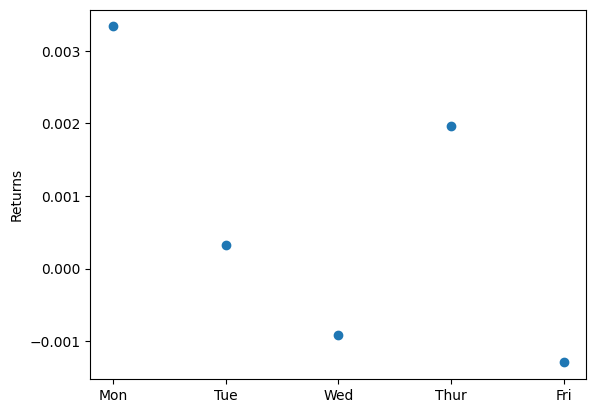

In [ ]:
plt.scatter(['Mon','Tue','Wed','Thur', 'Fri'], daily_ret)
plt.ylabel('Returns')

In [ ]:
df['Total Returns'] = (1 + df['Returns']).cumprod()-1
df

,Datetime,Close,Date,Volatility,Volume,tag_vt,tag_vm,Returns,fl signal,pfl signal,MA1,MA2,Momentum,Signal,strat returns,Cumulative Returns,Total Returns
0,26-08-2022 09:16,17632.0000,2022-08-26,12.70,266636240,m,m,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN
1,26-08-2022 09:46,17625.0508,2022-08-26,12.70,266636240,m,m,-0.000394,0,0,NaN,NaN,0.999606,-1,-0.000000,0.000000,-0.000394
2,26-08-2022 10:16,17600.5000,2022-08-26,12.70,266636240,m,m,-0.001393,0,0,NaN,NaN,0.998607,-1,0.001393,0.001393,-0.001787
3,26-08-2022 10:46,17588.5508,2022-08-26,12.70,266636240,m,m,-0.000679,0,0,17611.5254,NaN,0.999321,-1,0.000679,0.002073,-0.002464
4,26-08-2022 11:16,17615.9492,2022-08-26,12.70,266636240,m,m,0.001558,0,0,17607.5127,NaN,1.001558,1,-0.001558,0.000512,-0.000910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,06-04-2023 13:16,17569.6504,2023-04-06,11.81,242708336,m,m,-0.002767,0,0,17603.4751,17603.61865,0.997233,0,0.002767,0.062981,-0.003536
1959,06-04-2023 13:46,17579.4492,2023-04-06,11.81,242708336,m,m,0.000558,0,0,17597.7749,17601.74975,1.000558,1,0.000000,0.062981,-0.002980
1960,06-04-2023 14:16,17594.5000,2023-04-06,11.81,242708336,m,m,0.000856,0,0,17590.5000,17602.09985,1.000856,1,0.000856,0.063891,-0.002127
1961,06-04-2023 14:46,17594.8496,2023-04-06,11.81,242708336,m,m,0.000020,0,0,17584.6123,17599.13110,1.000020,1,0.000020,0.063912,-0.002107


MOVING AVERAGE CROSSOVER STRATEGY

6.373700998520682


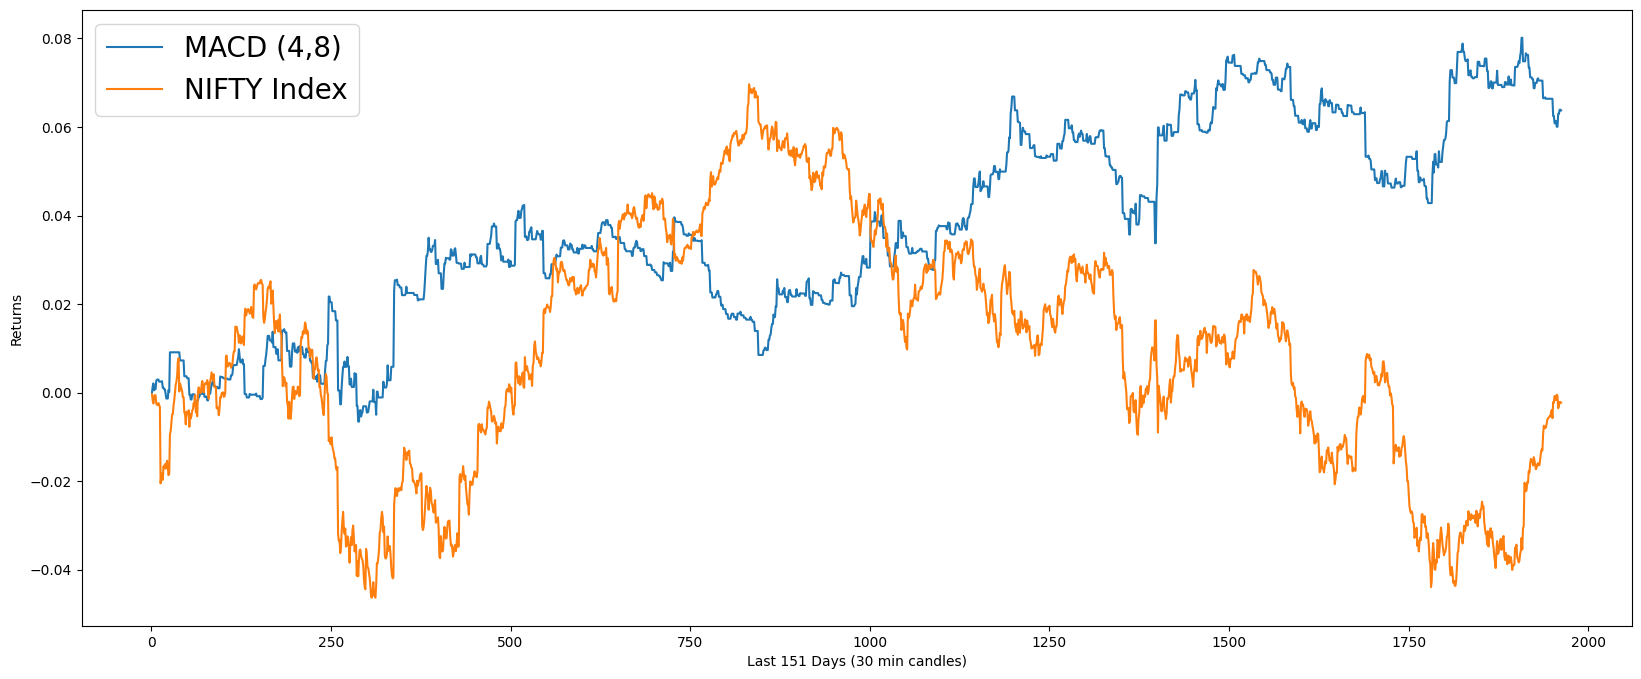

In [ ]:
def macd(df, series):
    data = df
    data['Close'] = df[series]

    # calculate the 50-day and 200-day moving averages
    n1 = 4
    n2 = 8
    data['MA1'] = data['Close'].rolling(window=n1).mean()
    data['MA2'] = data['Close'].rolling(window=n2).mean()

    # create a new column for the momentum indicator
    data['Momentum'] = data['Close'] / data['Close'].shift(1)

    # create buy and sell signals based on the momentum indicator crossing the moving averages
    data['Signal'] = 0
    data.loc[data['Momentum'] > 1, 'Signal'] = 1
    data.loc[data['Momentum'] < 1, 'Signal'] = -1
    data.loc[(data['MA1'] > data['MA2']) & (data['Signal'] == 1), 'Signal'] = 0
    data.loc[(data['MA1'] < data['MA2']) & (data['Signal'] == -1), 'Signal'] = 0

    # calculate the daily returns
    data['strat returns'] = data['Close'].pct_change() * data['Signal'].shift(1)

    # calculate the cumulative returns
    data['Cumulative Returns'] = (1 + data['strat returns']).cumprod()-1
    # plot the cumulative returns
    data['Cumulative Returns'].plot(figsize=(20, 8), label = "MACD (4,8)")
    data['Total Returns'].plot(figsize=(20, 8), label = "NIFTY Index")
    plt.legend(loc='upper left', fontsize = 20)
    plt.ylabel('Returns')
    plt.xlabel("Last 151 Days (30 min candles)")


    return data


macd_data = macd(df, 'Close')
print(macd_data['Cumulative Returns'][len(macd_data)-1]*100)


In [ ]:
trade_pts = macd_data[macd_data['Returns']!=0]
trade_pass = macd_data[macd_data['Returns']>0]
trade_fail = macd_data[macd_data['Returns']<0]
ret_macd = macd_data['Cumulative Returns'][len(macd_data)-1]
print("MACD Monthly returns :", round(ret_macd*100,3), "%")
print("Profitable Trades :", len(trade_pass), "/", len(trade_pts), "(", round(len(trade_pass)*100/len(trade_pts),3), "% )")
print("-----------------------------------------------------------------------")


MACD Monthly returns : 6.374 %
Profitable Trades : 997 / 1960 ( 50.867 % )
-----------------------------------------------------------------------


EXPONENTIAL MOVING AVERAGE CROSSOVER STRATEGY

0.030380089472250793


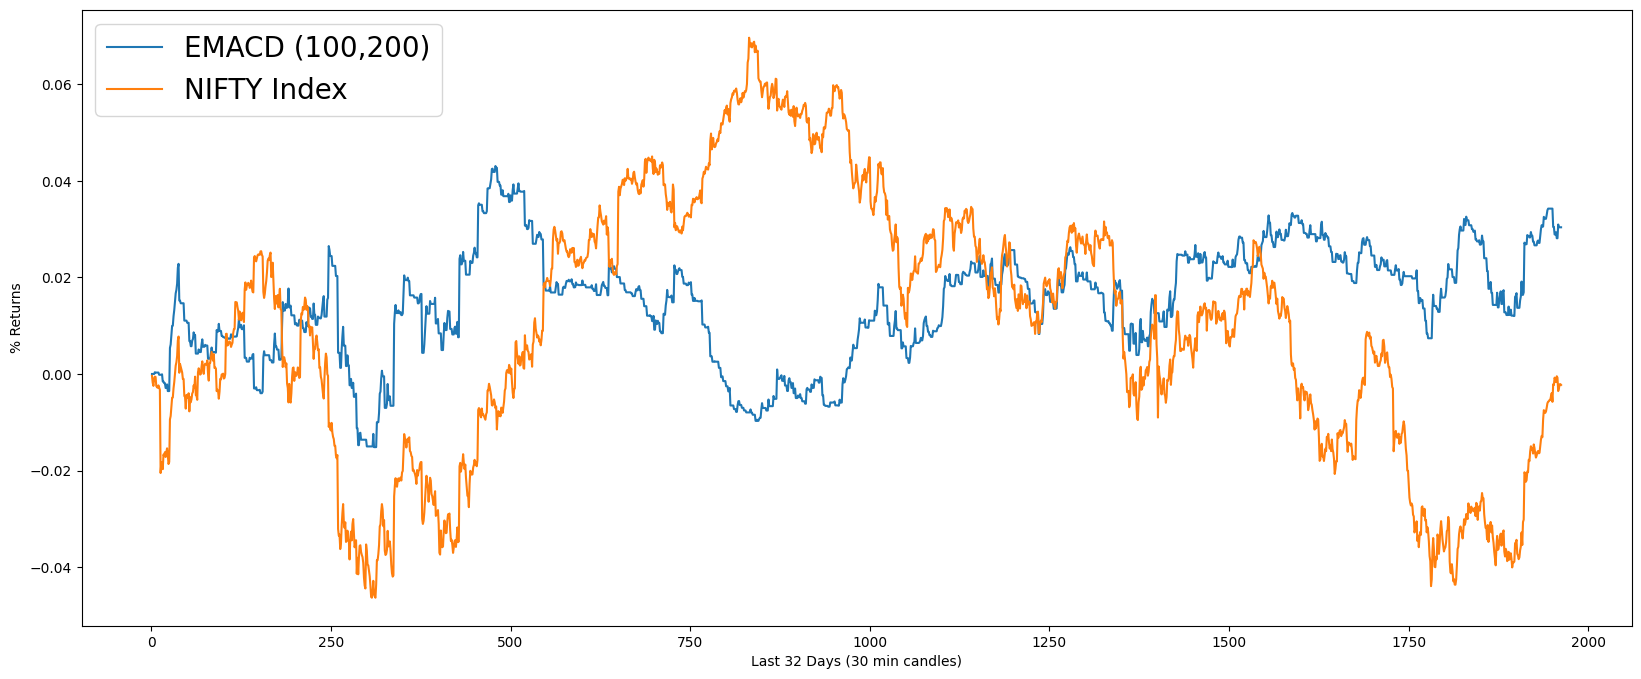

In [ ]:
def emacd(df, series):
    data = df
    data['Close'] = df[series]
    # calculate the 50-day and 200-day moving averages
    n1 = 100
    n2 = 200
    data['MA1'] = data['Close'].ewm(span = n1, adjust = False).mean()
    data['MA2'] = data['Close'].ewm(span = n2, adjust = False).mean()

    # create a new column for the momentum indicator
    data['Momentum'] = data['Close'] / data['Close'].shift(1)

    # create buy and sell signals based on the momentum indicator crossing the moving averages
    data['Signal'] = 0
    data.loc[data['Momentum'] > 1, 'Signal'] = 1
    data.loc[data['Momentum'] < 1, 'Signal'] = -1
    data.loc[(data['MA1'] > data['MA2']) & (data['Signal'] == 1), 'Signal'] = 0
    data.loc[(data['MA1'] < data['MA2']) & (data['Signal'] == -1), 'Signal'] = 0

    # calculate the daily returns
    data['Returns'] = data['Close'].pct_change() * data['Signal'].shift(1)

    # calculate the cumulative returns
    data['Cumulative Returns'] = (1 + data['Returns']).cumprod()-1

    data['Cumulative Returns'].plot(figsize=(20, 8), label = "EMACD (100,200)")
    data['Total Returns'].plot(figsize=(20, 8), label = "NIFTY Index")
    plt.legend(loc='upper left', fontsize = 20)
    plt.ylabel('% Returns')
    plt.xlabel("Last 32 Days (30 min candles)")

    # plot the cumulative returns
    #data['Cumulative Returns'].plot(figsize=(20, 8))

    return data


emacd_data = emacd(df, 'Close')
print(emacd_data['Cumulative Returns'][len(emacd_data)-1])

In [ ]:
trade_pts_e = emacd_data[emacd_data['Returns']!=0]
trade_pass_e = emacd_data[emacd_data['Returns']>0]
trade_fail_e = emacd_data[emacd_data['Returns']<0]
ret_emacd = emacd_data['Cumulative Returns'][len(emacd_data)-1]
print("Monthly returns :", round(ret_emacd*100,3), "%")
print("Profitable Trades :", len(trade_pass_e), "/", len(trade_pts_e), "(", round(len(trade_pass_e)*100/len(trade_pts_e),3), "% )")
print("-----------------------------------------------------------------------")

Monthly returns : 3.038 %
Profitable Trades : 504 / 983 ( 51.272 % )
-----------------------------------------------------------------------


RSI DIVERGENCE STRATEGY

In [ ]:
import pandas as pd

# Load historical price data
dfr = pd.DataFrame()
dfr['Date'] = df['Date']
dfr['Close']=df['Close']
dfr['Total Returns'] = df['Total Returns']

# Set the number of periods for RSI calculation
rsi_period = 48

# Calculate the price change and average gain/loss for each period
dfr['Price_Change'] = dfr['Close'].diff()
dfr['Gain'] = dfr['Price_Change'].apply(lambda x: x if x > 0 else 0)
dfr['Loss'] = dfr['Price_Change'].apply(lambda x: abs(x) if x < 0 else 0)
dfr['Avg_Gain'] = dfr['Gain'].rolling(window=rsi_period).mean()
dfr['Avg_Loss'] = dfr['Loss'].rolling(window=rsi_period).mean()

# Calculate the RSI
dfr['RS'] = dfr['Avg_Gain'] / dfr['Avg_Loss']
dfr['RSI'] = 100 - (100 / (1 + dfr['RS']))

# Remove unnecessary columns
#dfr.drop(['Price_Change', 'Gain', 'Loss', 'Avg_Gain', 'Avg_Loss', 'MA1', 'MA2', 'Momentum', 'Signal', 'Returns', 'Total Returns', 'Highs', 'Lows'], axis=1, inplace=True)

dfr.tail()

,Date,Close,Total Returns,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI
1958,2023-04-06,17569.6504,-0.003536,-48.7500,0.0000,48.7500,15.042725,5.262492,2.858480,74.083056
1959,2023-04-06,17579.4492,-0.002980,9.7988,9.7988,0.0000,11.644775,5.262492,2.212787,68.874379
1960,2023-04-06,17594.5000,-0.002127,15.0508,15.0508,0.0000,11.958333,5.146892,2.323409,69.910412
1961,2023-04-06,17594.8496,-0.002107,0.3496,0.3496,0.0000,11.965617,4.540608,2.635245,72.491540
1962,2023-04-06,17591.9492,-0.002271,-2.9004,0.0000,2.9004,11.842692,4.601033,2.573920,72.019519


In [ ]:
# Calculate RSI divergence
rsi_window = 14
dfr['RSI_Signal'] = np.nan
dfr['Price_Signal'] = np.nan
for i in range(rsi_period+rsi_window, len(dfr)):
    rsi_values = dfr.loc[i-rsi_period:i, 'RSI']
    price_values = dfr.loc[i-rsi_period:i, 'Close']

    rsi_change = rsi_values.iloc[-1] - rsi_values.iloc[0]
    price_change = price_values.iloc[-1] - price_values.iloc[0]
    if rsi_change > 0 and price_change < 0:
        dfr.loc[dfr.index[i], 'RSI_Signal'] = 1
    elif rsi_change < 0 and price_change > 0:
        dfr.loc[dfr.index[i], 'RSI_Signal'] = -1
    else:
        dfr.loc[dfr.index[i], 'RSI_Signal'] = 0
    dfr.loc[dfr.index[i], 'Price_Signal'] = np.sign(price_change)

# Backtest
dfr['Returns'] = dfr['Close'].pct_change()
dfr['Strategy_Returns'] = dfr['Returns'] * dfr['RSI_Signal'].shift(1)
dfr['Cumulative_Returns'] = (1 + dfr['Strategy_Returns']).cumprod()-1

dfr.tail(15)

,Date,Close,Total Returns,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI,RSI_Signal,Price_Signal,Returns,Strategy_Returns,Cumulative_Returns
1948,2023-04-05,17551.4004,-0.004571,14.0996,14.0996,0.0000,16.437542,5.498983,2.989196,74.932295,0.0,1.0,0.000804,0.0,0.06324
1949,2023-04-05,17562.4492,-0.003945,11.0488,11.0488,0.0000,16.667725,4.440675,3.753421,78.962522,0.0,1.0,0.000630,0.0,0.06324
1950,2023-04-06,17530.2500,-0.005771,-32.1992,0.0000,32.1992,16.667725,4.978150,3.348177,77.001854,0.0,1.0,-0.001833,-0.0,0.06324
1951,2023-04-06,17594.4004,-0.002132,64.1504,64.1504,0.0000,18.004192,4.697917,3.832378,79.306254,0.0,1.0,0.003659,0.0,0.06324
1952,2023-04-06,17591.6992,-0.002286,-2.7012,0.0000,2.7012,17.865642,4.754192,3.757872,78.982199,0.0,1.0,-0.000154,-0.0,0.06324
1953,2023-04-06,17618.5996,-0.000760,26.9004,26.9004,0.0000,17.889608,4.754192,3.762913,79.004444,0.0,1.0,0.001529,0.0,0.06324
1954,2023-04-06,17610.3496,-0.001228,-8.2500,0.0000,8.2500,17.598958,4.926067,3.572619,78.130694,0.0,1.0,-0.000468,-0.0,0.06324
1955,2023-04-06,17602.2500,-0.001687,-8.0996,0.0000,8.0996,16.530233,5.094808,3.244525,76.440238,0.0,1.0,-0.000460,-0.0,0.06324
1956,2023-04-06,17623.5996,-0.000476,21.3496,21.3496,0.0000,16.975017,4.138550,4.101682,80.398622,0.0,1.0,0.001213,0.0,0.06324
1957,2023-04-06,17618.4004,-0.000771,-5.1992,0.0000,5.1992,15.228108,4.246867,3.585728,78.193211,0.0,1.0,-0.000295,-0.0,0.06324


In [ ]:
trade_pts_r = dfr[dfr['Strategy_Returns']!=0]
trade_pass_r = dfr[dfr['Strategy_Returns']>0]
trade_fail_r = dfr[dfr['Strategy_Returns']<0]
ret_rsid = dfr['Cumulative_Returns'][len(dfr)-1]
print("6-Month returns :", round(ret_rsid*100,3), "%")
#print("Profitable Trades :", len(trade_pass_r), "/", len(trade_pts_r), "(", round(len(trade_pass_r)*100/len(trade_pts_r),3), "% )")
print("-----------------------------------------------------------------------")

6-Month returns : 6.324 %
-----------------------------------------------------------------------


Text(0.5, 0, 'Last 151 Days (30 min candles)')

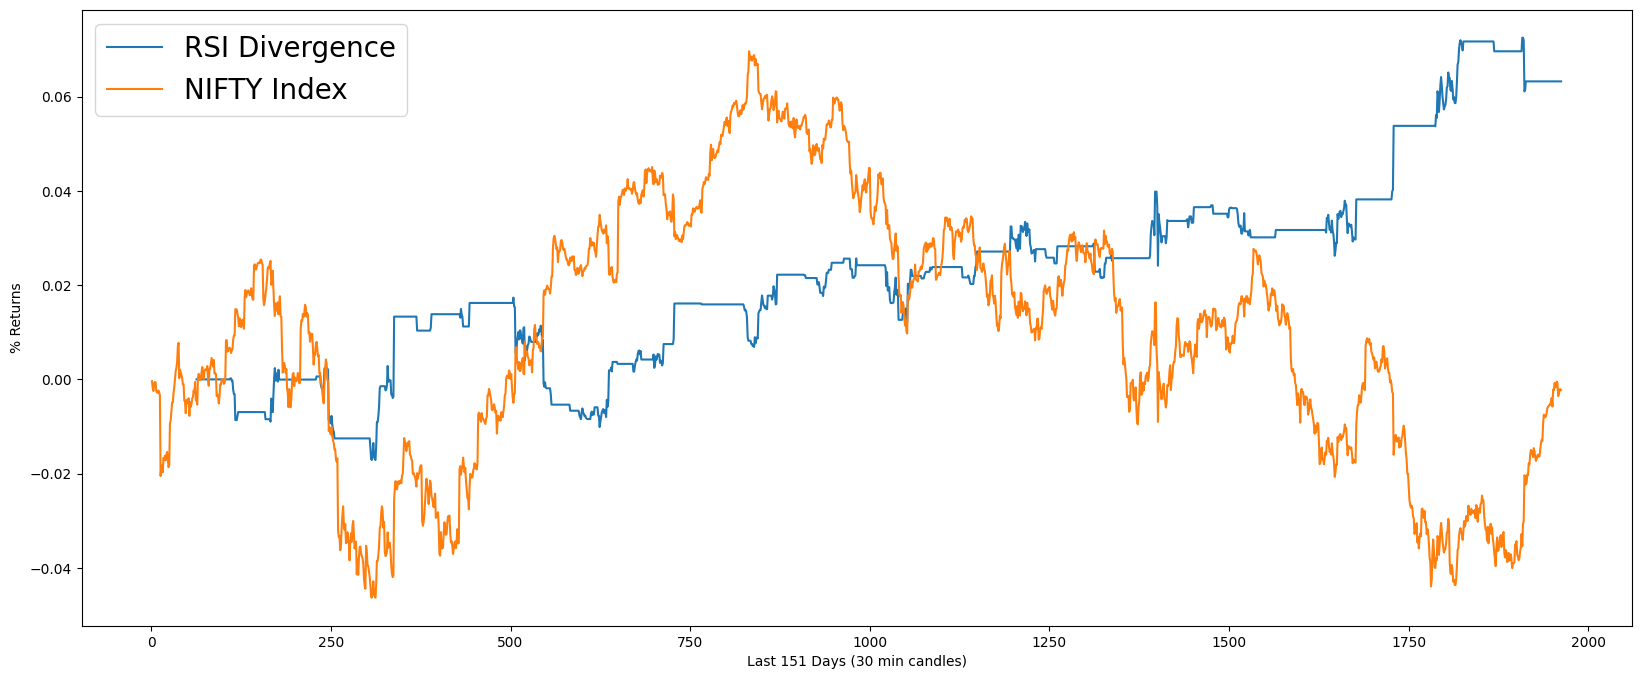

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(dfr['Cumulative_Returns'], label = "RSI Divergence")
plt.plot(dfr['Total Returns'], label = "NIFTY Index")
plt.legend(loc='upper left', fontsize = 20)
plt.ylabel('% Returns')
plt.xlabel("Last 151 Days (30 min candles)")